In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Graph Convolutional Networks (GCN)
        
No geral, métodos para extração de caracterésticas não capturam informações sobre a vizinhança de um nó em um grafo, as quais podem ser essenciais para alguns tipos de tarefas.

Redes neurais em grafos resolvem esse problema ao considerar tanto a informação de cada amostra como das suas relações com o restante do grafo para extrair essas características. 

Como o nome sugere, a GCN é uma rede neural que trabalha com dados em grafos, e o seu principal objetivo é refinar as informações presentes tanto no grafo em si como nos atributos de cada nó em um vetor de características. A figura abaixo apresenta uma idéia intuitiva da GCN de [Kipf and Welling (2016)](https://arxiv.org/abs/1609.02907). 
![](https://drive.google.com/uc?export=view&id=1liHJYh4Dte88zRPzjkWuk74UNrov5xPy)

Nesta aula, vamos usar o pacote `stellargraph` [(docs)](https://stellargraph.readthedocs.io/en/stable/) e sua implementação de GCN. 

Os autores fornecem um bom exemplo de aplicação usando jupyter [aqui](https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html).

Vamos entender o que acontece em cada camada da rede e como aplicar esse modelo para _datasets_ reais.

## Importando os pacotes

In [ ]:
#!pip install stellargraph
#!pip uninstall umap -y
#!pip install umap-learn

In [ ]:
import pandas as pd
from tqdm import tqdm
import json
import os
import umap.umap_ as umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix


import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import warnings
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Dados
---

Vamos comecar baixando o dataset de usuários do github, disponível [aqui](https://snap.stanford.edu/data/github-social.html). Usaremos o dataset para classificar se o usuário é desenvolvedor web ou de ML. Nesse dataset, os nós representam usuários do github que deram estrela para mais de 10 repositórios, as arestas representam seguidores em comum, e as características representam a localização, repositórios com estrelas, empregador e e-mail.

### Baixando e extraindo o dataset

In [ ]:
!wget "https://snap.stanford.edu/data/git_web_ml.zip"
!unzip git_web_ml.zip

--2022-07-05 21:05:32--  https://snap.stanford.edu/data/git_web_ml.zip
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396031 (2.3M) [application/zip]
Saving to: ‘git_web_ml.zip.4’

git_web_ml.zip.4    100%[===================>]   2.28M  8.38MB/s    in 0.3s    

2022-07-05 21:05:32 (8.38 MB/s) - ‘git_web_ml.zip.4’ saved [2396031/2396031]

Archive:  git_web_ml.zip
replace git_web_ml/musae_git_edges.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: git_web_ml/musae_git_edges.csv  
  inflating: git_web_ml/musae_git_features.json  
  inflating: git_web_ml/musae_git_target.csv  
  inflating: git_web_ml/citing.txt   
  inflating: git_web_ml/README.txt   


### Lendo as arestas, características e rótulos

In [ ]:
#'/content/drive/MyDrive/Colab Notebooks/git_web_ml/musae_git_edges.csv'
edges_path = '/content/git_web_ml/musae_git_edges.csv'
targets_path = '/content/git_web_ml/musae_git_target.csv'
features_path = '/content/git_web_ml/musae_git_features.json'

### Definindo um número menor de amostras

Faremos isso para treinar mais rápido e evitar erro de crash de memória 

In [ ]:
num_samples = 10000 # -> vai ditar a matriz de adjascência -> (10k, 10k)

In [ ]:
# lendo as arestas
edges = pd.read_csv(edges_path)
edges.columns = ['source', 'target'] # renaming for StellarGraph compatibility
display(edges.shape, edges.head())

(289003, 2)

,source,target
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [ ]:
edges = edges[edges['target'] <num_samples]
edges = edges[edges['source'] <num_samples]
display(edges.shape, edges.head())
# qual o problema desse corte??

(18057, 2)

,source,target
2,1,2370
11,3,4950
13,3,3358
15,3,5916
16,4,2865


In [ ]:
# lendo as caracteristicas
with open(features_path) as json_data:
    features = json.load(json_data)

max_feature = np.max([v for v_list in features.values() for v in v_list])
# features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))
features_matrix = np.zeros(shape = (num_samples, max_feature+1))

# Vamos criar uma sparse matrix...
i = 0
for k, vs in tqdm(features.items()):
    if i<num_samples:
        for v in vs:
            features_matrix[i, v] = 1
        i+=1

100%|██████████| 37700/37700 [00:00<00:00, 315968.05it/s]


In [ ]:
# node_features = pd.DataFrame(features_matrix, index = features.keys())
node_features = pd.DataFrame(features_matrix, index = np.arange(num_samples).astype(str))
display(node_features.shape, node_features.head())

(10000, 4005)

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# lendo os rótulos
targets = pd.read_csv(targets_path)
targets.index = targets.id.astype(str)
targets = targets.loc[np.arange(num_samples).astype(str), :]
display(targets.shape, targets.head(), targets.ml_target.value_counts(normalize=True))

(10000, 3)

,id,name,ml_target
id,,,
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


0    0.7402
1    0.2598
Name: ml_target, dtype: float64

Então temos 37700 desenvolvedores, 289003 seguidores em comum e 4005 características. Aproximadamente 75% dos usuários são desenvolvedores web e 25% são desenvolvedores de ML.

### Dados no StellarGraph

O `stellargraph` tem sua própria estrutura de dados com diversas funcionalidades. Para transformar nossos dados para o formato do StellarGraph é muito simples, precisando apenas passar os dataframes com as características dos nós e as arestas para a função `StellarGraph`. A API também aceita arestas ponderadas, nós heterogeneos, tipos de arestas e nós direcionados.

In [ ]:
G = sg.StellarGraph(node_features, edges.astype(str))
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 10000, Edges: 18057

 Node types:
  default: [10000]
    Features: float32 vector, length 4005
    Edge types: default-default->default

 Edge types:
    default-default->default: [18057]
        Weights: all 1 (default)
        Features: none


### Conjunto de Treino, Teste e validação

Como de costume, precisamos separar os dados em treino, validação e teste. 

A GCN é, em partes, um modelo semi-supervisionado, o que significa que precisa de um número reduzido de rótulos que técnicas supervisionadas para o aprendizado. 

Suponha que tenhamos apenas 1% dos dados rotulados, ou seja, 400 desenvolvedores. Nesse caso, usaremmos 200 deles para treinamento e os outros 200 para validação. O restante será usado para teste.

In [ ]:
train_pages, test_pages = train_test_split(targets, train_size=200)
val_pages, test_pages = train_test_split(test_pages, train_size=200)

In [ ]:
train_pages.shape, val_pages.shape, test_pages.shape

((200, 3), (200, 3), (9600, 3))

## Pré-processamento

### Pré-processamento dos rótulos

In [ ]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_pages['ml_target'])
val_targets = target_encoding.transform(val_pages['ml_target'])
test_targets = target_encoding.transform(test_pages['ml_target'])

# print(train_pages['ml_target'])
# print(train_targets)

### Pré-processamento do grafo

Essa é a principal parte para o funcionamento de GCN. 

Para entender o tipo de processamento que faremos, vamos das uma olhada no que as camadas convolucionais em grafo fazem...

O que queremos é, de alguma forma, agregar a informação das características dos nós vizinhos visto que queremos aprender as representações que reflitam a vizinhança do grafo. 

Em CNNs, que são normalmente usadas para imagens, esse objetivo é alcançado usando operações de convolução entre kernels e pixels. A intensidade do nó (pixel) vizinho (ex.: 3x3) é passada pelo kernel que tira a média dos pixels e computa um único valor. Isso funciona porque em imagens os vizinhos são ordenados e tem tamanho fixo. Porém, não temos essas qualidades em grafos, portanto, precisamos de uma alternativa diferente.



![](https://drive.google.com/uc?export=view&id=1LWb4Lc4Nhqzm0GteBM1jZ-0ib4fjlRBQ)

A alternativa é usar a idéia de passar a infomação multiplicando os estados ocultos pela matriz de adjacência. A matriz de adjacência representa a conexão entre os nós. Sendo assim, multiplicando os estados ocultos (ou os nós com as características, para a primeira camada) por ela, estamos de certa forma aplicando uma máscara e agregando apenas a informação dos nós vizinhos. Os conceitos podem ser vistos em detalhe nesse [vídeo](https://www.youtube.com/watch?v=ijmxpItkRjc&t=524s).

Nossa tarefa agora é pré-computar essa parte não "treinável" do algoritmo. Para isso, usaremos a implementação do stellargraph, que executa esses cálculos em um formato esparso para melhorar a velocidade.

In [ ]:
# Pega a matriz de adjacências do grafo
A = G.to_adjacency_matrix(weighted=False)

# Adiciona conexões dos nós com eles mesmos (se a representação fosse baseada apenas nos vizinhos, sem considerar as características do proprio nó)
A_t = A + sp.diags(np.ones(A.shape[0]) - A.diagonal())

# Computa o grau da matriz e eleva -1/2 (grau e o numero de vizinhos, e eleva a -1/2 para ajudar na normalizacao)
D_t = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)

# Normaliza a matriz de adjacências
A_norm = A.dot(D_t).transpose().dot(D_t).todense()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


Agora que pré-processamos nossos dados para a GCN, devemos seguir mais algumas formalidades antes de treinar o modelo:

1. Obter os novos índices dos conjuntos de treinamento, validação e teste - necessários para computar o custo do modelo.
2. Adicionar uma dimensão extra para os nossos dados (necessário pela implementação das redes - pense como se fosse um minibatch com uma única amostra)

In [ ]:
# Definindo uma função para obter esses índices
def get_node_indices(G, ids):
    # encontra os indices dos nós
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # usa funcao in-built 
    # volta para o formato original
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # adiciona uma dimensao extra
    
    return node_indices

train_indices = get_node_indices(G, train_pages.index)
val_indices = get_node_indices(G, val_pages.index)
test_indices = get_node_indices(G, test_pages.index)

In [ ]:
# Expandindo para a  dimensão extra
features_input = np.expand_dims(features_matrix, 0)
A_input = np.expand_dims(A_norm, 0)

y_train = np.expand_dims(train_targets, 0)
y_val = np.expand_dims(val_targets, 0)
y_test = np.expand_dims(test_targets, 0)

Agora que os dados estçao normalizados e no formato correto, podemos começar a modelagem da rede.

## Modelo GCN

Analisando friamente, as camadas GCN não passam de multiplicações de valores de entrada, pesos, e a matriz de adjacência normalizada. 

Quem tiver interesse, pode ver como é feita implementação em `stellargraph`'s `GraphConvolution` [aqui](https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/layer/gcn.py), nas linhas 208 e 209.

In [ ]:
from stellargraph.layer.gcn import GraphConvolution, GatherIndices

# Inicializando os parametros da GCN
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.3
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

Primeiramente, vamos inicializar a camada de entrada com os formatos corretos para receber 3 entradas:

1. Matriz de características
2. Índices de treinamento/teste/validação
3. Matriz de adjacência normalizada

In [ ]:
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]
x_inp

[<KerasTensor: shape=(1, 10000, 4005) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
 <KerasTensor: shape=(1, 10000, 10000) dtype=float32 (created by layer 'input_3')>]

Agora, podemos construir um modelo GCN com 2 camadas e _dropout_. 

Cada camada terá 32 unidades, que devem ser suficientes para transformar os dados o obter boas representações.

In [ ]:
x = Dropout(dropout)(x_features)

x = GraphConvolution(layer_sizes[0], activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(dropout)(x)
x = GraphConvolution(layer_sizes[1], activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 10000, 4005)]   0           []                               
                                                                                                  
 dropout (Dropout)              (1, 10000, 4005)     0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(1, 10000, 10000)]  0           []                               
                                                                                                  
 graph_convolution (GraphConvol  (1, 10000, 32)      128192      ['dropout[0][0]',                
 ution)                                                           'input_3[0][0]']            

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [ ]:
es_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    x = [features_input, train_indices, A_input],
    y = y_train,
    batch_size = 32,
    epochs=200,
    validation_data=([features_input, val_indices, A_input], y_val),
    verbose=1,
    shuffle=False,
    callbacks=[es_callback],
)

Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.6941 - acc: 0.5150 - val_loss: 0.6704 - val_acc: 0.7600
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.6743 - acc: 0.7350 - val_loss: 0.6329 - val_acc: 0.7600
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.6413 - acc: 0.7350 - val_loss: 0.5860 - val_acc: 0.7600
Epoch 4/200
1/1 [==============================] - 1s 917ms/step - loss: 0.5993 - acc: 0.7350 - val_loss: 0.5486 - val_acc: 0.7600
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.5651 - acc: 0.7350 - val_loss: 0.5301 - val_acc: 0.7600
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 0.5412 - acc: 0.7350 - val_loss: 0.5194 - val_acc: 0.7600
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: 0.5108 - acc: 0.7400 - val_loss: 0.5036 - val_acc: 0.7650
Epoch 8/200
1/1 [==============================] - 1s 1s/step - loss: 0.4850 - acc: 0.7450 - val_loss

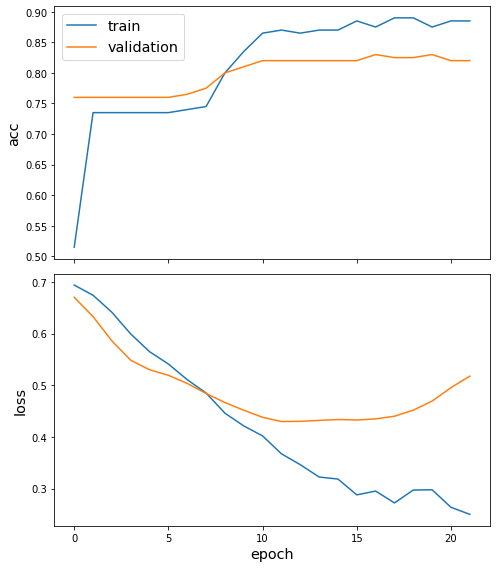

In [ ]:
sg.utils.plot_history(history)

## Avaliando o modelo

Agora que treinamos o modelo, vamos avaliar sua acurácia sobre o conjunto de teste.

In [ ]:
test_preds = model.predict([features_input, test_indices, A_input])

In [ ]:
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    print('ROC AUC:', auc)
    print('PR AUC:', pr)
    print('F1 score:', f_score)
    print(confusion_matrix(true, bin_pred, normalize='true'))
    
    return auc, pr, f_score

In [ ]:
auc, pr, f_score = evaluate_preds(test_targets.ravel(),test_preds[0].ravel())

ROC AUC: 0.8030920787896341
PR AUC: 0.5799618527903075
F1 score: 0.4624145785876994
[[0.97142053 0.02857947]
 [0.67480977 0.32519023]]


Temos uma pontuação ROC AUC com 0.80, mas que poderia ser melhorada para aproximadamente 0.89 se nao fosse o corte brusco no _dataset_, assim como as demais métricas. Vamos visualizar como ficaram as representações.

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)
all_indices = get_node_indices(G, targets.index)
emb = embedding_model.predict([features_input, all_indices, A_input])
emb.shape

(1, 10000, 32)

In [ ]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


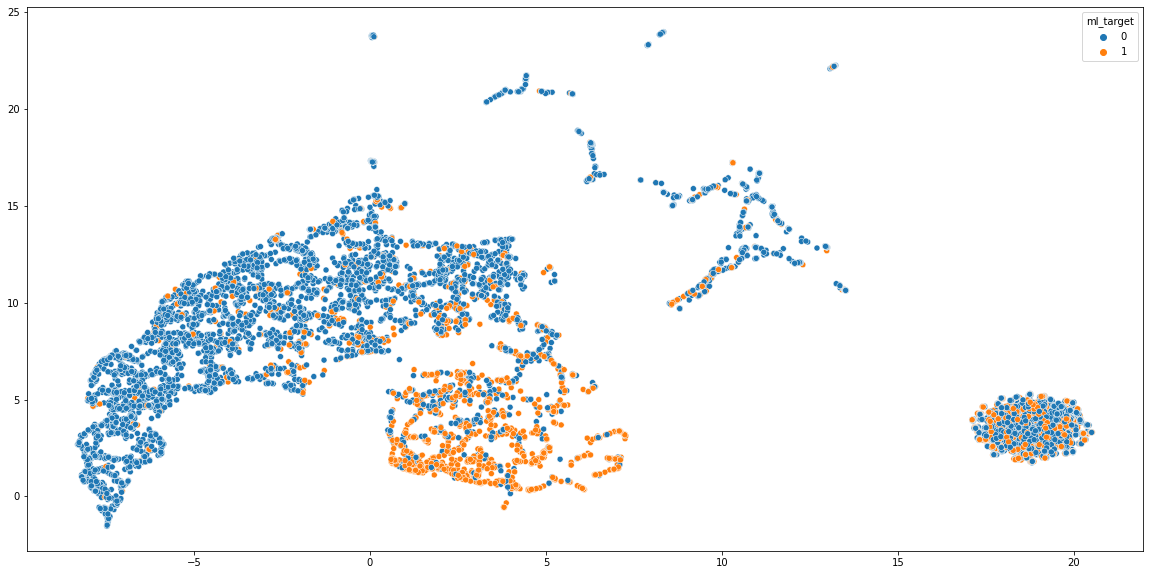

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = targets['ml_target'])

No plot conseguimos identificar que o algoritmo conseguiu separar razoavelmente bem as 2 classes, mas deixou um _cluster_ de fora. 

Provavelmente, esse cluster extra foi criado devido às amostras e arestas que cortamos para economizar memória.

## Conclusões...
---

As GCNs são redes neurais poderosas que permitem combinar informações obtidas a partir das características dos nós e da vizinhanca. Tal propriedade é alcançada multiplicando as saídas das camadas anteriores pela matriz de adjacência normalizada, o que performa uma operação similar a um filtro de convolução. 

As características dos filtros vizinhos são agregadas e se tornam representações muito úteis para serem aprendidas e usadas no _backpropagation_, como de costume.

## Exercícios

1. Arranjar o dataset de modo que exclua todas as amostras com ID maior que 10000, e que nao fique nenhum nó sem vizinhos (todos os vizinhos foram excluídos). Testar se melhora os resultados do modelo.